## Test of DetSim

In [2]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy     as np
import pandas    as pd
from   scipy     import stats
import os
import matplotlib.pyplot as plt

import xyimg.dataprep as dp
import xyimg.detsim   as dsim
#import xyimg.cnn      as cnn

## Tests

In [42]:
pressure = '5bar'
sample   = '1eroi'

path      = os.environ['LPRDATADIR']
ifilename = path + dp.voxel_filename(pressure, sample)
ofile     = 'temp.h5'


In [44]:
dsim.test(ifilename)

True

In [46]:
voxels = pd.read_hdf(ifilename, 'voxels')

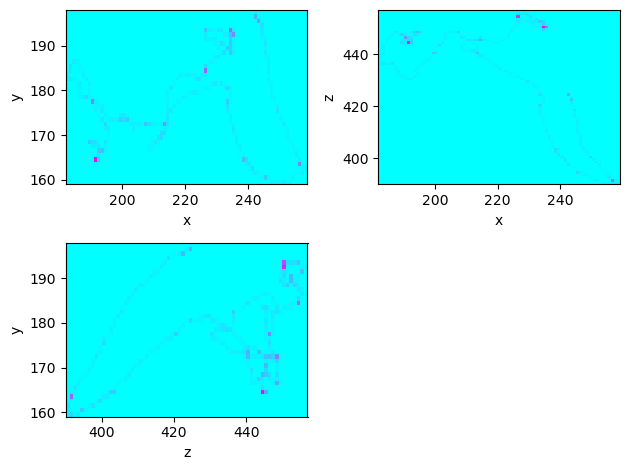

In [47]:
evt = dsim.df_event(voxels, 1, 1)
width = (2., 2., 2.)
bins = [dsim.mmbins(xi, wi) for wi, xi in zip(width, (evt.x, evt.y, evt.z))]
dsim.plot_event(evt, scatter = False, bins = bins)

,file_id,event,x,y,z,E,binclass,segclass,track_id,nhits,ext,nielectron
0,1,1,182.398977,182.686963,436.913108,25.637616,0,1,0,2,0,151
1,1,1,182.796680,182.200219,436.309757,25.637616,0,1,0,2,0,151
2,1,1,182.024318,182.678382,436.178253,25.637616,0,1,0,2,0,151


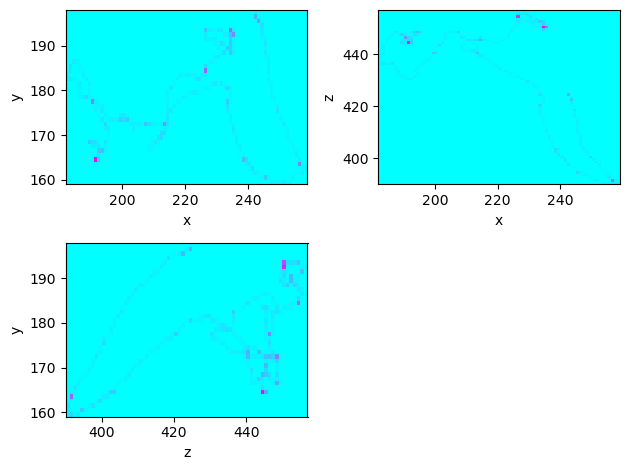

In [48]:
width = (2., 2., 2.)
dfie = dsim.create_df_ielectrons(evt, width)
dsim.plot_event(dfie, scatter = False, bins = bins)
dfie[:3]

True

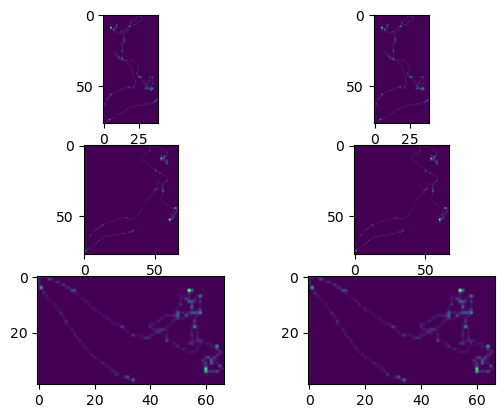

In [49]:
dsim.test_create_df_ielectrons(evt, width, plot = True)

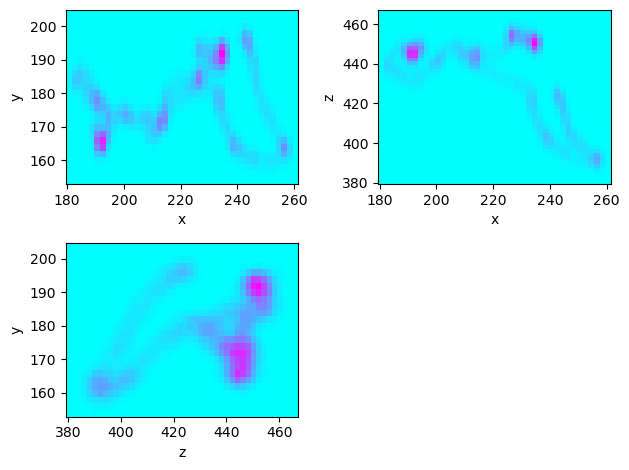

In [50]:
dfie0 = dfie.copy()
sigma = (1, 2, 3)
dfie = dsim.df_norma(dfie, sigma)
dsim.plot_event(dfie, scatter = False)

,file_id,event,x,y,z,E,binclass,segclass,track_id,nhits,ext,nielectron
0,1,1,181.745102,183.573336,440.200394,25.637616,0,1,0,2,0,151
1,1,1,182.318687,178.237113,437.173132,25.637616,0,1,0,2,0,151
2,1,1,183.208980,183.226912,429.206442,25.637616,0,1,0,2,0,151


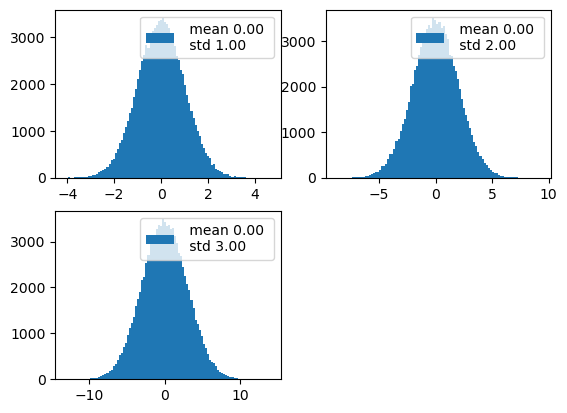

In [51]:
dsim.test_df_norma(dfie, sigma, plot = True)
dfie[:3]

In [52]:
width   = (2, 2, 2)
dfvoxel = dsim.df_voxalize(dfie, width)
dfvoxel[:3]

file_id  event           x           y           z          E  \
ix iy iz                                                                  
1  37 64        1      1  176.432060  187.335796  438.163841  25.635369   
2  28 63        1      1  178.323485  178.182782  437.006539  25.637616   
   37 70        1      1  178.411633  187.152983  444.383230  25.635369   

          binclass  segclass  track_id  nhits  ext  nielectron  ix  iy  iz  
ix iy iz                                                                    
1  37 64         0         1         0    1.0    0           1   1  37  64  
2  28 63         0         1         0    2.0    0           1   2  28  63  
   37 70         0         1         0    1.0    0           1   2  37  70

In [53]:
dsim.test_df_voxalize(dfie, width)

True

# Debuging

In [62]:
width   = (2, 2, 2)
sigma   = (4, 4, 4)
nevents = 10
dv = dsim.run(ifilename, ofile, width, sigma, width, nevents = nevents)

input  filename  /scratch/next/data/NEXT100/pressure_topology/voxel_dataset_5bar_1eroi.h5
output filename  temp.h5
width-0    (mm)  (2, 2, 2)
sigmas     (mm)  (4, 4, 4)
widths-1   (mm)  (2, 2, 2)
wi         (eV)  25.6
events           10
Index(['file_id', 'event', 'x', 'y', 'z', 'E', 'binclass', 'segclass',
       'track_id', 'nhits', 'ext', 'nielectron', 'ix', 'iy', 'iz'],
      dtype='object')
Index(['file_id', 'event', 'x', 'y', 'z', 'E', 'binclass', 'segclass',
       'track_id', 'nhits', 'ext', 'nielectron', 'ix', 'iy', 'iz'],
      dtype='object')
Index(['file_id', 'event', 'x', 'y', 'z', 'E', 'binclass', 'segclass',
       'track_id', 'nhits', 'ext', 'nielectron', 'ix', 'iy', 'iz'],
      dtype='object')
Index(['file_id', 'event', 'x', 'y', 'z', 'E', 'binclass', 'segclass',
       'track_id', 'nhits', 'ext', 'nielectron', 'ix', 'iy', 'iz'],
      dtype='object')
Index(['file_id', 'event', 'x', 'y', 'z', 'E', 'binclass', 'segclass',
       'track_id', 'nhits', 'ext', 'nielectron'

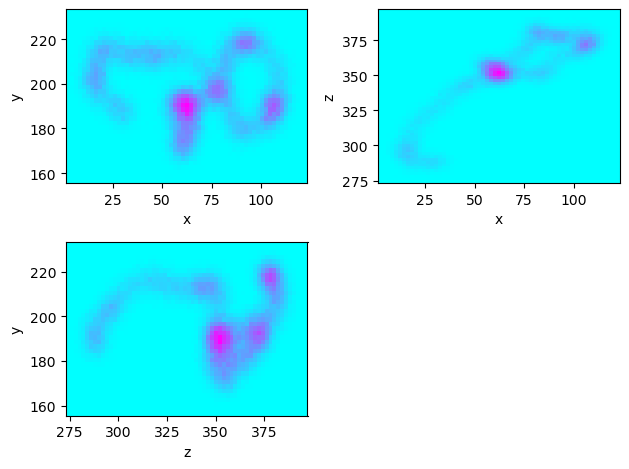

In [71]:
evt = dsim.df_event(dv, 1, 7)
dsim.plot_event(evt, scatter = False)

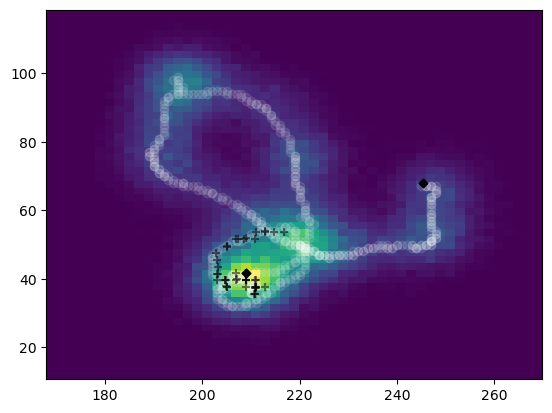

In [269]:
i0, i1 = 1, 2
plt.hist2d(xpos[i0], xpos[i1], weights = xene, bins = (bins[i0], bins[i1]));
plt.scatter(pos[i0], pos[i1], alpha = 0.1, color = 'white')
plt.scatter(xpos[i0][xsegclass == 3], xpos[i1][xsegclass == 3], alpha = .5, color = 'black', marker='+')
plt.scatter(xpos[i0][xext > 0], xpos[i1][xext > 0], alpha = 1., color = 'black', marker='D', s = 20)



In [48]:
np.sum(ene), np.sum(ie_ene)

(2.457999998430296, 2.457999998430296)

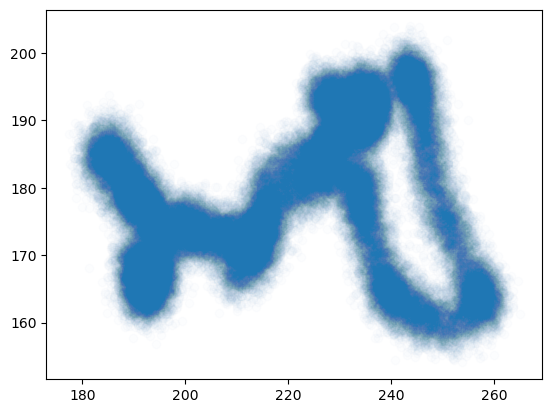

In [54]:
plt.scatter(ie_pos[0], ie_pos[1], alpha = 0.01)

In [1]:
ievt = evt[['x', 'y', 'z', 'E']]

NameError: name 'evt' is not defined

In [62]:
ievt

,x,y,z,E
490,182,182,436,0.003871
491,182,182,437,0.001494
492,182,182,438,0.001365
493,182,183,438,0.002234
494,182,183,439,0.005366
...,...,...,...,...
919,256,164,392,0.003523
920,257,161,390,0.006627
921,257,162,391,0.003436
922,257,163,391,0.004179


In [63]:
np.sum(ievt.E)

2.457999998430296

In [40]:
smear = dsim.get_smear(0., 0., 0.)

In [41]:
svoxels = [smear(voxel.x, voxel.y, voxel.z, voxel.E) for i, voxel in ievt.iterrows()]

In [44]:
ie_pos = [np.concatenate([s[i] for s in svoxels]) for i in range(2)]
ie_ene = np.concatenate([s[3] for s in svoxels])

In [58]:
width = 2.
bins  = [np.arange(np.min(x) - 2.*width, np.max(x) + 2.*width, width) for x in ie_pos]

In [59]:
img , _, _ = stats.binned_statistic_dd(ie_pos, ie_ene,  bins = bins, statistic = 'count')

In [60]:
np.sum(img) * 25.*1e-6

2.4006499999999997

In [61]:
np.sum(ie_ene)

2458265.6

In [39]:
len(xs)

96026

In [33]:
x, y, z, E = [evt[label].values for label in ('x', 'y', 'z', 'E')]

In [62]:
ivoxel = 0
wi     = 25.
x0, y0, z0, E0 = x[ivoxel], y[ivoxel], z[ivoxel], E[ivoxel]
nsize = int(np.round(1e6*E0/wi))
print(x0, y0, z0, E0, nsize)

182 182 436 0.003871280001476407 155


In [73]:
smear                = dsim.get_smear(25., 2., 2., 2.)
positions, energies  = smear((x[ivoxel], y[ivoxel], z[ivoxel]), E[ivoxel])

In [74]:
white = 20 # mm
voxel_width = 2. #3 mm
frames = [(np.min(x) - white , np.max(x) + white) for x in (x, y, z)] 
bins   = [np.arange(*iframe, voxel_width) for iframe in frames]


In [75]:
index = (0, 1)
coors = [positions[i] for i in index]
cbins = [bins[i]    for i in index]
var   = energies
img , _, _ = stats.binned_statistic_dd(coors, var,  bins = cbins, statistic = 'count')

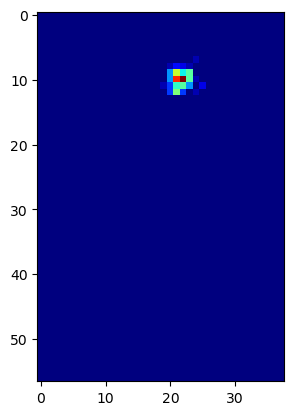

In [76]:
plt.imshow(img, cmap = 'jet')

In [ ]:
result = evt[['x', 'y', 'z', 'E']]

: 